In [10]:
from owslib.wfs import WebFeatureService
import json
from owslib.fes import *


wfs11 = WebFeatureService(url='https://entw-imis.lab.bfs.de/ogc/opendata/wfs', version='1.1.0')

#filter1 = PropertyIsGreaterThanOrEqualTo(propertyname='start', literal='2022-01-01')
#filter1 = PropertyIsBetween(propertyname='start', lower='2021-01-01' ,upper= str(prevdate) + ' 23:00:00')
filter1 = PropertyIsBetween(propertyname='start', lower='2021-01-01' ,upper= '2022-12-31')
#filter1 = PropertyIsBetween(propertyname='start_measure', lower='2022-11-01',upper='2022-11-02')
filter2 = PropertyIsLike(propertyname='id', literal='DEZ3159',wildCard='*')
#filter3 = PropertyIsLike(propertyname='network', literal='BfS',wildCard='*')
#filters3= PropertyIsLike(propertyname='local_authority', literal='Ulm',wildCard='*')
filters=[filter1,filter2]

filterxml = etree.tostring(And(operations=filters).toXML()).decode("utf-8")

#dd =webbrowser.open(' https://entw-imis.lab.bfs.de/ogc/opendata/wfs?typeName=opendata:public_odl_brutto_1h&_dc=1665655122146&service=WFS&version=1.1.0&request=GetFeature&outputFormat=application%2Fjson&srsname=EPSG%3A3857&cql_filter=id%20%3D%20%27DEZ2634%27%20AND%20end_measure%3E%272020-01-01T00%3A00%3A00.000Z%27%20AND%20end_measure%3C%272022-12-20T00%3A00%3A00.000Z%27')

#odlinfo_timeseries_precipitation_15min
#odlinfo_timeseries_odl_1h
#opendata:public_odl_brutto_1h
#opendata:odl_brutto_1h
response = wfs11.getfeature(typename='opendata:public_odl_brutto_1h',filter = filterxml,outputFormat='application/json')

# convert IO-byte to bytes
bytesD=bytes(response.read())
# convert to json
data2 = json.loads(bytesD)


In [ ]:
#save json to show in qgis
import json
with open('Halberstadt' + '.json', 'w', encoding='utf-8') as f:
    json.dump(data2, f, ensure_ascii=False, indent=4)

In [70]:
#Describe data
import pandas as pd
datanorm1= pd.json_normalize(data2,"features")
df2=pd.DataFrame(datanorm1)



In [ ]:
print(df2.sum())
print(df2.info())
print(df2["properties.value"].describe())

#print(df1[['geometry.type','geometry.coordinates','properties.id','properties.locality_name','properties.start','properties.end_measure']].describe())
#print(df1[['properties.unit','properties.value_e','properties.nuclide','properties.duration','properties.dom','properties.source','properties.network_id']].describe())
#print(df1[['geometry.type','geometry.coordinates','properties.id','properties.locality_name','properties.start','properties.end_measure','properties.unit','properties.value']].head())

In [65]:
#list of duplicate
#print(df2[df2["properties.end_measure"].isin(df2["properties.end_measure"][df2["properties.end_measure"].duplicated()])].sort_values("properties.end_measure"))

#print(df2["properties.end_measure"].drop_duplicates())

# check duplicate
duplicatef2 = df2[df2['properties.end_measure'].duplicated()]
print(duplicatef2)

Empty DataFrame
Columns: [type, id, geometry_name, geometry.type, geometry.coordinates, properties.id, properties.locality_name, properties.start, properties.end_measure, properties.unit, properties.value_e, properties.value, properties.nuclide, properties.duration, properties.dom, properties.source, properties.network_id]
Index: []


In [71]:
#prepare data to plot
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


df2['properties.end_measure'] = pd.to_datetime(df2['properties.end_measure']).dt.tz_localize(None)
df2['properties.start'] = pd.to_datetime(df2['properties.start']).dt.tz_localize(None)
df2 = df2.set_index(df2['properties.end_measure'])
#print(df2['properties.value'].loc['2021-04-30'])


In [ ]:
# dates which are not in the sequence are returned
missv=pd.date_range(start="2021-01-01 00:00:00", end="2022-12-31 23:00:00", freq = 'H').difference(df2.index)
#print(missv.sort_values(ascending=True))
print(pd.DataFrame(missv).count())
missv = np.array(pd.to_datetime(missv.sort_values(ascending=True)))
print(missv)

In [72]:
import seaborn as sns

df2=df2.resample('D').mean()


/tmp/ipykernel_694652/4220050370.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2=df2.resample('D').mean()


In [69]:
# check null values
isnulldf2 = df2[df2['properties.value'].isnull()]
print(isnulldf2)

                        properties.value
properties.end_measure                  
2021-04-30                           NaN
2021-05-01                           NaN
2021-05-02                           NaN
2021-05-03                           NaN
2021-05-04                           NaN
2021-09-07                           NaN
2021-09-08                           NaN
2021-09-09                           NaN
2021-09-17                           NaN
2021-09-18                           NaN
2021-09-19                           NaN
2021-09-20                           NaN
2021-09-21                           NaN
2021-10-26                           NaN
2022-10-29                           NaN


Text(0, 0.5, 'GADR (μSv/d)')

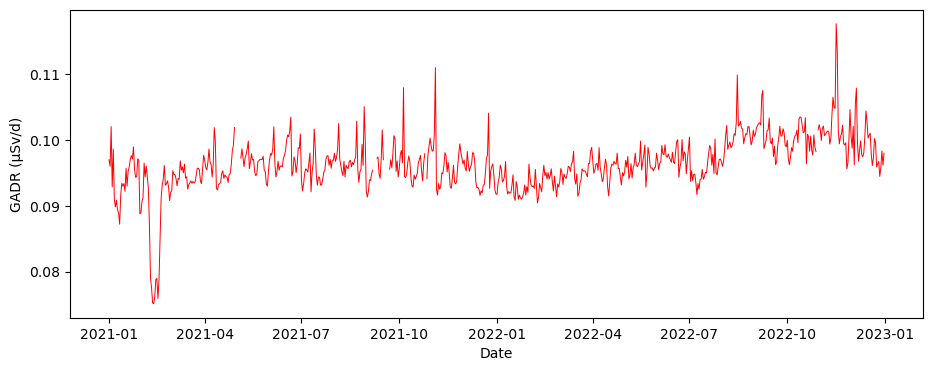

In [78]:

import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(11, 4))
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month
ax.xaxis.set_major_formatter(year_month_formatter) # formatter for major axis only
ax.plot(df2.index.values,df2['properties.value'],linewidth=0.7,color='red')


#sns.set(rc={'figure.figsize':(11, 4)})
#df1['properties.value'].plot(linewidth=0.7)

# Giving title to the chart using plt.title
#plt.title('Daily GADR at Halberstadt station (2021-2022)')
 
# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('GADR (μSv/d)')

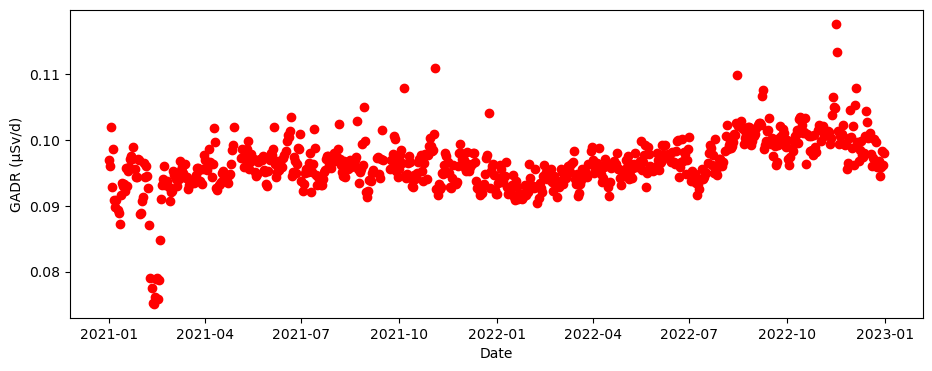

In [77]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(11, 4))

# Add x-axis and y-axis
ax.scatter(df2.index.values,
           df2['properties.value'],
           color='red')

# Set title and labels for axes
# title="Daily GADR Distribution at Halberstadt Station (2021-2022)"
ax.set(xlabel="Date",
       ylabel="GADR (μSv/d)")

plt.show()

In [ ]:
import seaborn as sns

df2=df2.resample('W').mean()
df2.plot(style='k.')
#plt.savefig('filename.jpg')
plt.show()

In [ ]:
df2=df2.resample('W').mean()
sns.set(rc={'figure.figsize':(11, 4)})
df2['properties.value'].plot(linewidth=0.9)

In [ ]:
df2=df2.resample('D').mean()
# create the time series plot
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(ax=ax,x = df2.index.values, y = "properties.value",
             data = df2)
  
#plt.xticks(rotation = 25)

In [ ]:

df2=df2.resample('W').mean()
# create the time series plot
sns.set_style()
  
sns.lineplot(x = df2.index.values, y = "properties.value",
             data = df2)
  
#plt.xticks(rotation = 25)

In [ ]:
from pandas import DataFrame
from pandas import Grouper
from pandas import concat
import seaborn as sns

df2 = df2.resample('M').mean()
df2 = df2.sort_index().loc['2021-01-01':'2021-12-31']
print(df1.head())

sns.set_style("whitegrid")
  
sns.boxplot(x = df1.index.values, y = df1['properties.value'], data = df1)

In [ ]:
import seaborn as sns
df2['properties.end_measure'] = pd.to_datetime(df2['properties.end_measure']).dt.tz_localize(None)
df2['properties.start'] = pd.to_datetime(df2['properties.end_measure']).dt.tz_localize(None)
df1 = df2.set_index(df2['properties.end_measure'])
print(df1.sort_values(by='properties.start', ascending=False).head())
df1=df1.resample('D').sum()
sns.set(rc={'figure.figsize':(11, 4)})
# Create figure and plot space
fig, ax = plt.subplots(figsize=(8, 5))

# Add x-axis and y-axis
ax.scatter(df1.index.values,
           df1['properties.value'],
           color='blue')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="ODL (μSv/h)",
       title="Daily ODL - Lüder/Langenbrügge Station 2021-2022")
df1['properties.value'].plot(linewidth=0.5)